# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile, join
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data


In [2]:
Datapath = "ArSAS.txt"
Data = [l for l in open(Datapath,encoding='utf-8-sig').readlines() if isfile(Datapath)]
Data

['#Tweet_ID\tTweet_text\tTopic\tSentiment_label\tSentiment_label_confidence\tSpeech_act_label\tSpeech_act_label_confidence\n',
 '929241870508724224\tالمباراة القـادمة #غانا x #مصر الجولة الأخيرة من المجموعة الـ 5 تصفيات كاس العالم 2018 روسـيا ترتيب مصر : المركز الاول 12 نقطة ( تم حسم التأهل للمونديال ) غــدا الساعة 5:30 ع قناة : بين ســبورت 1 تـــوقعاتكم لـ نتيجة الماتش .؟ 😀😁 https://t.co/RTQBNZXDqM\tEvent\tPositive\t0.38\tAssertion\t0.62\n',
 '928942264583376897\tهل هذه هي سياسة خارجيه لدوله تحترم نفسها والآخرين :#اليمن عدوان وحصار ل 3 سنوات #البحرين قمع حراك شعبها المسالم المطالب بالمساواة والعداله #سوريا #العراق دعموا الإرهاب وارسلوا المال والسلاح والانتحاريين #قطر حصار ومحاولة فرض الوصايه والآن #لبنان محاولة فرض وصايه علني!!\tEntity\tNegative\t1\tExpression\t0.68\n',
 '928615163250520065\tوزير خارجية فرنسا عن منتدى شباب العالم: شعرت بارتياح وأنا أتابعه من باريس - https://t.co/hSvsbEaeUz #youm\tEvent\tPositive\t0.69\tAssertion\t1\n',
 '931614713368186880\tومع السيسي و بشار و ايران و

In [3]:
Data = np.array(Data[1:])
tweets = [t.split('\t')[1].rstrip() for t in Data]
sentiments = [t.split('\t')[3].rstrip() for t in Data]
print(Data.shape)

(21064,)


In [4]:
print(tweets[0])
print("***********************************************************")
print(tweets[1])

المباراة القـادمة #غانا x #مصر الجولة الأخيرة من المجموعة الـ 5 تصفيات كاس العالم 2018 روسـيا ترتيب مصر : المركز الاول 12 نقطة ( تم حسم التأهل للمونديال ) غــدا الساعة 5:30 ع قناة : بين ســبورت 1 تـــوقعاتكم لـ نتيجة الماتش .؟ 😀😁 https://t.co/RTQBNZXDqM
***********************************************************
هل هذه هي سياسة خارجيه لدوله تحترم نفسها والآخرين :#اليمن عدوان وحصار ل 3 سنوات #البحرين قمع حراك شعبها المسالم المطالب بالمساواة والعداله #سوريا #العراق دعموا الإرهاب وارسلوا المال والسلاح والانتحاريين #قطر حصار ومحاولة فرض الوصايه والآن #لبنان محاولة فرض وصايه علني!!


In [5]:
np.unique(np.array(sentiments))

array(['Mixed', 'Negative', 'Neutral', 'Positive'], dtype='<U8')

In [6]:
for index, item in enumerate(sentiments):
    if item == "Mixed":
        sentiments[index] = "Neutral"

np.unique(np.array(sentiments))        

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

Text(0.5, 1.0, 'Number of each sentiment')

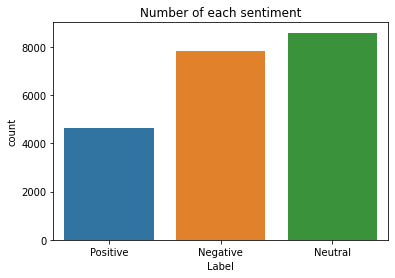

In [7]:
sns.countplot(sentiments)
plt.xlabel('Label')
plt.title('Number of each sentiment')

# Process the data

In [18]:
X = tweets
Y = sentiments
max_features = 1500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, padding='post')
type(X)

numpy.ndarray

# Split data into train and test 

In [19]:
Y = pd.get_dummies(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(15798, 53) (15798, 3)
(5266, 53) (5266, 3)


# build model

In [20]:
word_embedding_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, word_embedding_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 53, 128)           192000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 53, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 591       
Total params: 447,391
Trainable params: 447,391
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
 - 52s - loss: 1.0698 - accuracy: 0.4064
Epoch 2/7
 - 48s - loss: 1.0683 - accuracy: 0.4071
Epoch 3/7
 - 51s - loss: 1.0682 - accuracy: 0.4093
Epoch 4/7
 - 49s - loss: 1.0677 - accuracy: 0.4096
Epoch 5/7
 - 49s - loss: 1.0677 - accuracy: 0.4091
Epoch 6/7
 - 49s - loss: 1.0674 - accuracy: 0.4086
Epoch 7/7
 - 50s - loss: 1.0671 - accuracy: 0.4098


In [22]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.07
acc: 0.40


In [23]:
eX =["لقد كان يوما رائعا مع العائلة."]
tokenizer.fit_on_texts(eX)
eX = tokenizer.texts_to_sequences(eX)
eX = pad_sequences(eX, padding='post')
model.predict(eX)

ValueError: ignored

In [ ]:
print(eX)
print(X_train[0])